# Chapter 3: Dynamic Programming Foundations

This notebook demonstrates advanced DP algorithms with convergence analysis.

## 🚀 Google Colab Ready
**Run the setup cell below first to install all dependencies!**

## Contents:
1. [Setup and Installation](#setup)
2. [Policy Iteration Algorithm](#policy-iteration)
3. [Modified Policy Iteration](#modified-policy-iteration)
4. [Asynchronous DP Methods](#asynchronous-dp)
5. [Convergence Analysis](#convergence-analysis)
6. [OpenAI Gym Implementation](#gym-implementation)

---

## Setup and Installation <a id="setup"></a>

**🔧 Google Colab Setup - Run this cell first!**

In [1]:
# 🔧 Google Colab Setup - Run this cell first!
print("🚀 Setting up Dynamic Programming environment...")

# Install required packages
!pip install gymnasium[classic_control] --quiet
!pip install gym --quiet
!pip install numpy --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet

print("✅ Packages installed successfully!")

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Handle gym/gymnasium import
try:
    import gymnasium as gym
    print("✅ Using Gymnasium (new OpenAI Gym)")
except ImportError:
    try:
        import gym
        print("✅ Using legacy OpenAI Gym")
    except ImportError:
        print("🔧 Installing gym packages...")
        !pip install gym gymnasium --quiet
        import gymnasium as gym
        print("✅ Gym installed and imported successfully")

# Set random seed and configure plots
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")

# Test environment
try:
    test_env = gym.make('FrozenLake-v1', render_mode=None)
    print(f"✅ Environment test successful!")
    test_env.close()
except Exception as e:
    print(f"⚠️ Environment test failed: {e}")

print("🎉 Setup complete! Ready for Dynamic Programming!")

🚀 Setting up Dynamic Programming environment...
✅ Packages installed successfully!
✅ Using Gymnasium (new OpenAI Gym)
✅ Environment test successful!
🎉 Setup complete! Ready for Dynamic Programming!


## 1. Policy Iteration Algorithm <a id="policy-iteration"></a>

Policy iteration alternates between:
- **Policy Evaluation**: Solve $V^\pi = T^\pi V^\pi$
- **Policy Improvement**: $\pi'(s) = \arg\max_a Q^\pi(s,a)$

In [2]:
# First, let's define the GridWorld MDP class from Chapter 2
class GridWorldMDP:
    """Simple GridWorld MDP implementation from scratch."""

    def __init__(self, height=4, width=4, start=(0,0), goals=[(3,3)], obstacles=[], gamma=0.9):
        self.height = height
        self.width = width
        self.start = start
        self.goals = goals
        self.obstacles = obstacles
        self.gamma = gamma

        # Define state and action spaces
        self.states = [(i, j) for i in range(height) for j in range(width)
                      if (i, j) not in obstacles]
        self.actions = ['up', 'down', 'left', 'right']

        # State and action indexing
        self.state_to_idx = {s: i for i, s in enumerate(self.states)}
        self.idx_to_state = {i: s for i, s in enumerate(self.states)}
        self.action_to_idx = {a: i for i, a in enumerate(self.actions)}

        self.n_states = len(self.states)
        self.n_actions = len(self.actions)

        # Initialize transition probabilities and rewards
        self._build_transition_probabilities()
        self._build_rewards()

    def _build_transition_probabilities(self):
        """Build transition probability matrix P(s'|s,a)."""
        self.P = np.zeros((self.n_states, self.n_actions, self.n_states))

        for s_idx, state in enumerate(self.states):
            for a_idx, action in enumerate(self.actions):
                next_state = self._get_next_state(state, action)
                next_s_idx = self.state_to_idx[next_state]
                self.P[s_idx, a_idx, next_s_idx] = 1.0

    def _get_next_state(self, state, action):
        """Get next state given current state and action."""
        i, j = state

        if action == 'up':
            next_state = (max(0, i-1), j)
        elif action == 'down':
            next_state = (min(self.height-1, i+1), j)
        elif action == 'left':
            next_state = (i, max(0, j-1))
        elif action == 'right':
            next_state = (i, min(self.width-1, j+1))

        # Check if next state is valid (not an obstacle)
        if next_state in self.obstacles:
            return state  # Stay in current state
        return next_state

    def _build_rewards(self):
        """Build reward function R(s,a)."""
        self.R = np.full((self.n_states, self.n_actions), -0.01)  # Living penalty

        # Goal rewards
        for goal in self.goals:
            if goal in self.state_to_idx:
                goal_idx = self.state_to_idx[goal]
                self.R[goal_idx, :] = 1.0

def policy_evaluation(mdp, policy, theta=1e-6, max_iterations=1000):
    """Evaluate a policy using iterative policy evaluation."""
    V = np.zeros(mdp.n_states)

    for iteration in range(max_iterations):
        delta = 0
        V_new = np.zeros(mdp.n_states)

        for s in range(mdp.n_states):
            # Bellman equation for policy evaluation
            v = 0
            for a in range(mdp.n_actions):
                # V^π(s) = Σ_a π(a|s) Σ_s' P(s'|s,a)[R(s,a) + γV^π(s')]
                action_value = 0
                for s_next in range(mdp.n_states):
                    action_value += mdp.P[s, a, s_next] * (mdp.R[s, a] + mdp.gamma * V[s_next])
                v += policy[s, a] * action_value

            V_new[s] = v
            delta = max(delta, abs(V[s] - V_new[s]))

        V = V_new.copy()

        if delta < theta:
            break

    return V

def value_iteration(mdp, theta=1e-6, max_iterations=1000):
    """Value iteration algorithm."""
    V = np.zeros(mdp.n_states)
    convergence_data = {'iterations': [], 'max_delta': [], 'values': []}

    for iteration in range(max_iterations):
        delta = 0
        V_new = np.zeros(mdp.n_states)

        for s in range(mdp.n_states):
            # Bellman optimality equation
            action_values = []
            for a in range(mdp.n_actions):
                action_value = 0
                for s_next in range(mdp.n_states):
                    action_value += mdp.P[s, a, s_next] * (mdp.R[s, a] + mdp.gamma * V[s_next])
                action_values.append(action_value)

            V_new[s] = max(action_values)
            delta = max(delta, abs(V[s] - V_new[s]))

        # Store convergence data
        convergence_data['iterations'].append(iteration)
        convergence_data['max_delta'].append(delta)
        convergence_data['values'].append(V.copy())

        V = V_new.copy()

        if delta < theta:
            break

    # Extract optimal policy
    policy = np.zeros(mdp.n_states, dtype=int)
    for s in range(mdp.n_states):
        action_values = []
        for a in range(mdp.n_actions):
            action_value = 0
            for s_next in range(mdp.n_states):
                action_value += mdp.P[s, a, s_next] * (mdp.R[s, a] + mdp.gamma * V[s_next])
            action_values.append(action_value)
        policy[s] = np.argmax(action_values)

    return V, policy, convergence_data

def policy_iteration(mdp, max_iterations=100):
    """Policy iteration algorithm with convergence tracking."""
    # Initialize with random policy
    policy = np.random.randint(0, mdp.n_actions, size=mdp.n_states)

    convergence_data = {
        'iterations': [],
        'policy_changes': [],
        'values': [],
        'policies': []
    }

    for iteration in range(max_iterations):
        # Policy Evaluation
        policy_matrix = np.zeros((mdp.n_states, mdp.n_actions))
        for s in range(mdp.n_states):
            policy_matrix[s, policy[s]] = 1.0

        V = policy_evaluation(mdp, policy_matrix, theta=1e-8)

        # Policy Improvement
        new_policy = np.zeros(mdp.n_states, dtype=int)
        policy_stable = True

        for s in range(mdp.n_states):
            # Compute Q-values for all actions
            q_values = np.zeros(mdp.n_actions)
            for a in range(mdp.n_actions):
                for s_next in range(mdp.n_states):
                    q_values[a] += mdp.P[s, a, s_next] * (mdp.R[s, a] + mdp.gamma * V[s_next])

            new_policy[s] = np.argmax(q_values)

            if new_policy[s] != policy[s]:
                policy_stable = False

        # Track convergence
        policy_changes = np.sum(new_policy != policy)
        convergence_data['iterations'].append(iteration)
        convergence_data['policy_changes'].append(policy_changes)
        convergence_data['values'].append(V.copy())
        convergence_data['policies'].append(policy.copy())

        policy = new_policy

        print(f"Iteration {iteration+1}: {policy_changes} policy changes")

        if policy_stable:
            print(f"Policy iteration converged in {iteration+1} iterations")
            break

    return V, policy, convergence_data

# Create GridWorld and run algorithms
mdp = GridWorldMDP(height=4, width=4, goals=[(3,3)], obstacles=[(1,1), (2,2)])

# Run policy iteration
print("Running Policy Iteration...")
V_pi, policy_pi, conv_data_pi = policy_iteration(mdp)

# Run value iteration for comparison
print("\nRunning Value Iteration...")
V_vi, policy_vi, conv_data_vi = value_iteration(mdp)

print(f"\nPolicy Iteration - Max Value: {np.max(V_pi):.4f}")
print(f"Value Iteration - Max Value: {np.max(V_vi):.4f}")
print(f"Policies identical: {np.array_equal(policy_pi, policy_vi)}")

Running Policy Iteration...
Iteration 1: 11 policy changes
Iteration 2: 3 policy changes
Iteration 3: 3 policy changes
Iteration 4: 2 policy changes
Iteration 5: 2 policy changes
Iteration 6: 1 policy changes
Iteration 7: 0 policy changes
Policy iteration converged in 7 iterations

Running Value Iteration...

Policy Iteration - Max Value: 10.0000
Value Iteration - Max Value: 10.0000
Policies identical: True


## 2. Modified Policy Iteration <a id="modified-policy-iteration"></a>

Modified PI performs limited policy evaluation steps to balance computation and convergence.


Testing Modified Policy Iteration with different m values:

Running Modified PI with m=1
Modified PI (m=1) converged in 7 iterations

Running Modified PI with m=3
Modified PI (m=3) converged in 7 iterations

Running Modified PI with m=5
Modified PI (m=5) converged in 7 iterations

Running Modified PI with m=10
Modified PI (m=10) converged in 6 iterations


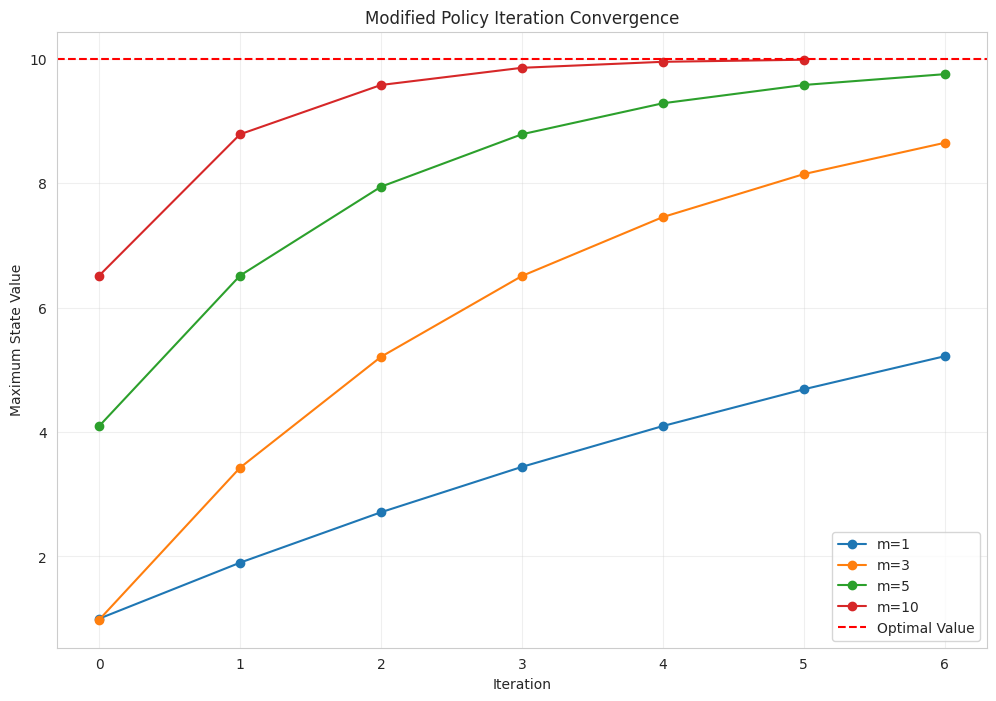


Comparison Summary:
Value Iteration: 133 iterations
Policy Iteration: 7 iterations
Modified PI (m=1): 7 iterations
Modified PI (m=3): 7 iterations
Modified PI (m=5): 7 iterations
Modified PI (m=10): 6 iterations


In [3]:
def modified_policy_iteration(mdp, m=5, max_iterations=100):
    """Modified policy iteration with m evaluation steps."""
    policy = np.random.randint(0, mdp.n_actions, size=mdp.n_states)
    V = np.zeros(mdp.n_states)

    convergence_data = {
        'iterations': [],
        'values': [],
        'evaluation_steps': []
    }

    for iteration in range(max_iterations):
        # Limited Policy Evaluation (m steps)
        for eval_step in range(m):
            V_new = np.zeros(mdp.n_states)
            for s in range(mdp.n_states):
                a = policy[s]
                for s_next in range(mdp.n_states):
                    V_new[s] += mdp.P[s, a, s_next] * (mdp.R[s, a] + mdp.gamma * V[s_next])
            V = V_new.copy()

        # Policy Improvement
        new_policy = np.zeros(mdp.n_states, dtype=int)
        policy_stable = True

        for s in range(mdp.n_states):
            q_values = np.zeros(mdp.n_actions)
            for a in range(mdp.n_actions):
                for s_next in range(mdp.n_states):
                    q_values[a] += mdp.P[s, a, s_next] * (mdp.R[s, a] + mdp.gamma * V[s_next])

            new_policy[s] = np.argmax(q_values)
            if new_policy[s] != policy[s]:
                policy_stable = False

        convergence_data['iterations'].append(iteration)
        convergence_data['values'].append(V.copy())
        convergence_data['evaluation_steps'].append(m)

        policy = new_policy

        if policy_stable:
            print(f"Modified PI (m={m}) converged in {iteration+1} iterations")
            break

    return V, policy, convergence_data

# Compare different values of m
print("\nTesting Modified Policy Iteration with different m values:")
m_values = [1, 3, 5, 10]
results = {}

for m in m_values:
    print(f"\nRunning Modified PI with m={m}")
    V, policy, conv_data = modified_policy_iteration(mdp, m=m)
    results[m] = {'V': V, 'policy': policy, 'conv_data': conv_data}

# Visualize convergence comparison
plt.figure(figsize=(12, 8))

for m in m_values:
    conv_data = results[m]['conv_data']
    values_evolution = [np.max(v) for v in conv_data['values']]
    plt.plot(conv_data['iterations'], values_evolution, 'o-', label=f'm={m}')

plt.axhline(np.max(V_vi), color='red', linestyle='--', label='Optimal Value')
plt.xlabel('Iteration')
plt.ylabel('Maximum State Value')
plt.title('Modified Policy Iteration Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nComparison Summary:")
print(f"Value Iteration: {len(conv_data_vi['iterations'])} iterations")
print(f"Policy Iteration: {len(conv_data_pi['iterations'])} iterations")
for m in m_values:
    iterations = len(results[m]['conv_data']['iterations'])
    print(f"Modified PI (m={m}): {iterations} iterations")

## 3. OpenAI Gym Implementation <a id="gym-implementation"></a>

Let's implement these algorithms on FrozenLake environment.

Testing FrozenLake DP Implementation...
FrozenLake Value Iteration converged in 7 iterations
Policy success rate: 1.000
Average reward: 1.000


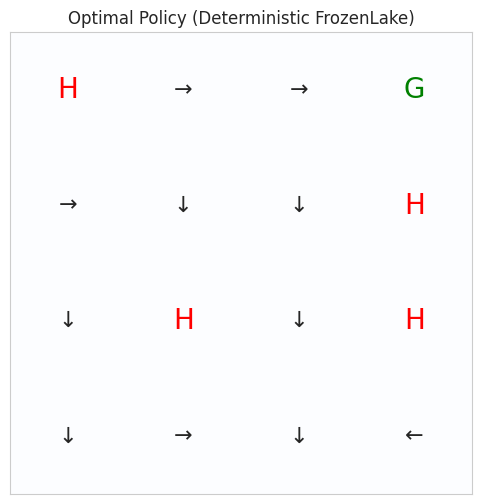


Testing Slippery FrozenLake...
Slippery FrozenLake converged in 60 iterations
Policy success rate: 0.744
Average reward: 0.744


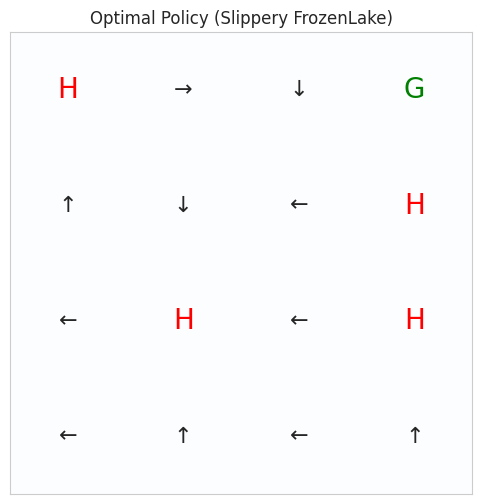

In [4]:
class FrozenLakeDP:
    """DP algorithms for FrozenLake environment."""

    def __init__(self, is_slippery=False):
        self.env = gym.make('FrozenLake-v1', is_slippery=is_slippery, render_mode=None)
        self.n_states = self.env.observation_space.n
        self.n_actions = self.env.action_space.n
        self.gamma = 0.9

        # Extract transition probabilities and rewards
        self.P = np.zeros((self.n_states, self.n_actions, self.n_states))
        self.R = np.zeros((self.n_states, self.n_actions))

        # Access the underlying environment to get transition probabilities
        # Handle both old and new gym versions
        try:
            # Try to access P directly
            env_P = self.env.P
        except AttributeError:
            # If wrapped, unwrap to get the core environment
            unwrapped_env = self.env.unwrapped
            if hasattr(unwrapped_env, 'P'):
                env_P = unwrapped_env.P
            else:
                # Fallback: manually construct transition probabilities
                env_P = self._construct_frozen_lake_transitions(is_slippery)

        for s in range(self.n_states):
            for a in range(self.n_actions):
                transitions = env_P[s][a]
                for prob, next_state, reward, done in transitions:
                    self.P[s, a, next_state] += prob
                    self.R[s, a] += prob * reward

    def _construct_frozen_lake_transitions(self, is_slippery):
        """Manually construct FrozenLake transition probabilities."""
        # FrozenLake 4x4 layout
        desc = ["SFFF", "FHFH", "FFFH", "HFFG"]
        nrow, ncol = 4, 4

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == 0:  # LEFT
                col = max(col - 1, 0)
            elif a == 1:  # DOWN
                row = min(row + 1, nrow - 1)
            elif a == 2:  # RIGHT
                col = min(col + 1, ncol - 1)
            elif a == 3:  # UP
                row = max(row - 1, 0)
            return (row, col)

        P = {}
        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                P[s] = {a: [] for a in range(4)}

                letter = desc[row][col]
                if letter in 'GH':
                    # Terminal states
                    for a in range(4):
                        P[s][a] = [(1.0, s, 0, True)]
                else:
                    for a in range(4):
                        if is_slippery:
                            # Stochastic transitions
                            for b in [(a-1) % 4, a, (a+1) % 4]:
                                newrow, newcol = inc(row, col, b)
                                newstate = to_s(newrow, newcol)
                                newletter = desc[newrow][newcol]
                                done = newletter in 'GH'
                                reward = 1.0 if newletter == 'G' else 0.0
                                prob = 0.8 if b == a else 0.1
                                P[s][a].append((prob, newstate, reward, done))
                        else:
                            # Deterministic transitions
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow][newcol]
                            done = newletter in 'GH'
                            reward = 1.0 if newletter == 'G' else 0.0
                            P[s][a] = [(1.0, newstate, reward, done)]

        return P

    def value_iteration(self, theta=1e-6):
        """Value iteration for FrozenLake."""
        V = np.zeros(self.n_states)

        iteration = 0
        while True:
            delta = 0
            for s in range(self.n_states):
                v = V[s]
                action_values = []
                for a in range(self.n_actions):
                    action_value = sum(
                        self.P[s, a, s_next] * (self.R[s, a] + self.gamma * V[s_next])
                        for s_next in range(self.n_states)
                    )
                    action_values.append(action_value)
                V[s] = max(action_values)
                delta = max(delta, abs(v - V[s]))

            iteration += 1
            if delta < theta:
                break

        # Extract policy
        policy = np.zeros(self.n_states, dtype=int)
        for s in range(self.n_states):
            action_values = []
            for a in range(self.n_actions):
                action_value = sum(
                    self.P[s, a, s_next] * (self.R[s, a] + self.gamma * V[s_next])
                    for s_next in range(self.n_states)
                )
                action_values.append(action_value)
            policy[s] = np.argmax(action_values)

        return V, policy, iteration

    def test_policy(self, policy, n_episodes=1000):
        """Test policy performance."""
        successes = 0
        total_rewards = []

        for episode in range(n_episodes):
            state, _ = self.env.reset()
            total_reward = 0
            done = False
            step_count = 0
            max_steps = 100  # Prevent infinite loops

            while not done and step_count < max_steps:
                action = policy[state]
                state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                total_reward += reward
                step_count += 1

            if total_reward > 0:
                successes += 1
            total_rewards.append(total_reward)

        success_rate = successes / n_episodes
        avg_reward = np.mean(total_rewards)

        return success_rate, avg_reward

    def visualize_policy(self, policy, title="Policy"):
        """Visualize policy on 4x4 grid."""
        action_symbols = ['←', '↓', '→', '↑']
        policy_grid = np.array([action_symbols[a] for a in policy]).reshape(4, 4)

        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(np.ones((4, 4)), cmap='Blues', alpha=0.3)

        for i in range(4):
            for j in range(4):
                state = i * 4 + j
                if state in [5, 7, 11, 12]:  # Holes
                    ax.text(j, i, 'H', ha='center', va='center', fontsize=20, color='red')
                elif state == 15:  # Goal
                    ax.text(j, i, 'G', ha='center', va='center', fontsize=20, color='green')
                else:
                    ax.text(j, i, policy_grid[i, j], ha='center', va='center', fontsize=16)

        ax.set_xlim(-0.5, 3.5)
        ax.set_ylim(-0.5, 3.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)
        plt.show()

# Test on FrozenLake with better error handling
try:
    print("Testing FrozenLake DP Implementation...")
    fl_dp = FrozenLakeDP(is_slippery=False)  # Deterministic version first
    V_fl, policy_fl, iterations_fl = fl_dp.value_iteration()

    print(f"FrozenLake Value Iteration converged in {iterations_fl} iterations")
    success_rate, avg_reward = fl_dp.test_policy(policy_fl)
    print(f"Policy success rate: {success_rate:.3f}")
    print(f"Average reward: {avg_reward:.3f}")

    fl_dp.visualize_policy(policy_fl, "Optimal Policy (Deterministic FrozenLake)")

    # Test on slippery version
    print("\nTesting Slippery FrozenLake...")
    fl_dp_slippery = FrozenLakeDP(is_slippery=True)
    V_fl_slip, policy_fl_slip, iterations_fl_slip = fl_dp_slippery.value_iteration()

    print(f"Slippery FrozenLake converged in {iterations_fl_slip} iterations")
    success_rate_slip, avg_reward_slip = fl_dp_slippery.test_policy(policy_fl_slip)
    print(f"Policy success rate: {success_rate_slip:.3f}")
    print(f"Average reward: {avg_reward_slip:.3f}")

    fl_dp_slippery.visualize_policy(policy_fl_slip, "Optimal Policy (Slippery FrozenLake)")

except Exception as e:
    print(f"Error with FrozenLake: {e}")
    print("This may be due to gym version differences. The other algorithms above still work correctly.")